* !pip install tensorflow
* !pip install embeddings
* !pip install keras

# PROJE 7: SENTIMENT ANALYSIS

Duygu analizi yapacağız, yani IMDB filmlerindeki insanların yorumlarını analiz edeceğiz. Bu yorumların olumlu mu yoksa olumsuz mu olduğunu belirleyeceğiz.

## Konu Başlıkları

1. [Python Kütüphaneleri](#1)
1. [Veri Seti ve Problem Tanımı](#2)
1. [Keşifsel Veri Analizi](#3)
1. [Preprocess: Padding ve Eğitim/Test Verisinin Ayrılması](#4)
1. [Recurrent Neural Network](#5)
1. [Recurrent Neural Network Eğitimi](#6)
1. [Sonuçların Değerlendirilmesi](#7)

<a id="1" ></a>
## Python Kütüphaneleri

In [ ]:
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences # her satırdaki kelime sayısı aynı olması için
from keras.models import Sequential # Sequential bir model yaratılacak
# gerekli olan tüm layer'ları Sequential'a ekleyeceğim yani bir dizi oluşturuyorum
from keras.layers import SimpleRNN, Dense, Activation, Embedding
# Embedding layer, integer'ları belirli boyutlarda yoğunluk vektörlerine
# çevirmemizde yardımcı olacak bir tane layer olacak bunu yaparken belirli bir kelime sayısı kullanacağız
# kelimeleri integer'dan layer'lara, vektörlere çevireceğiz
# sınıflandırma yapabilmek için Dense layer kullanacağız
# sınıflandırma yapabilmek için bir tane sigmoit fonksiyonu kullanacağız bunu Activation layer'ın içerisine ekleyeceğiz

<a id="2" ></a>
## Veri Seti ve Problem Tanımı

Bu, IMDB'den alınan ve duyarlılıklara göre (olumlu/olumsuz) etiketlenen 25.000 film incelemesinden oluşan bir veri kümesidir. İncelemeler önceden işlenmiştir ve her inceleme, kelime dizinlerinin (tamsayılar) bir listesi olarak kodlanmıştır. Kolaylık sağlamak amacıyla, kelimeler veri setindeki genel frekansa göre indekslenir, böylece örneğin "3" tam sayısı veride en sık görülen 3. kelimeyi kodlar. Bu, "yalnızca en yaygın 10.000 kelimeyi dikkate alın, ancak en yaygın 20 kelimeyi eleyin" gibi hızlı filtreleme işlemlerine olanak tanır.

Anlamsız bir kelime veya boşluk varsa bu 0 olarak adlandırıldı.

25.000 train veri seti - 25.000 test veri seti

toplam 50.000 veri

In [ ]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      # num_words=1000 en çok kullanılan 1000 kelimeyi getir diğerlerini getirme
                                                      num_words=None, # veri setinin içerisindeki tüm kelimeleri getir
                                                      skip_top=0, # 1 ise en sık kullanılan kelimeyi getirme
                                                      maxlen=None, # yorumun uzunluğu
                                                      seed=113, # veri üretilirken karıştırılır. aynı sırayı vermesi için
                                                      start_char=1, # yorumun hangi karakterden başlayacağını söyler 0 ise boş karaker
                                                      oov_char=2,
                                                      index_from=3
                                                     )

In [ ]:
print("Type x_train:", type(x_train))
print("Type y_train:", type(y_train))

Type x_train: <class 'numpy.ndarray'>
Type y_train: <class 'numpy.ndarray'>


In [ ]:
print("X train shape:", x_train.shape)
print("Y train shape:", y_train.shape)

X train shape: (25000,)
Y train shape: (25000,)


In [ ]:
# kelimelerin karşılık geldiği integer değerleri
x_train[0][:3]

[1, 14, 22]

In [ ]:
len(x_train[0])

218

In [ ]:
len(x_train)

25000

In [ ]:
x_train[:3]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1

<a id="3" ></a>
## Keşifsel-Açıklayıcı Veri Analizi (Exploratory Data Science)

* Yorumlardaki kelime sayıları incelenecek; kelime sayılarının dağılımlarına bakacağız.
* Yorumların uzunluğuna bakacağız; yorumların uzunluğunun dağılımına bakacağız.
* Tüm kelimeleri kullanmalı mıyız?
* Yorumların hepsini kullanmalı mıyız?

In [ ]:
# kaç tane sınıf var?
# binary classification
# yorumlar olumlu ve olumsuz olarak sınıflandırılmıştı
print("y_train values:", np.unique(y_train))
print("y_test values:", np.unique(y_test))

y_train values: [0 1]
y_test values: [0 1]


In [ ]:
# sınıfların dağılımlarına bakalım
unique, counts = np.unique(y_train, return_counts = True)
print("y_train distribution:", dict(zip(unique, counts)))

y_train distribution: {0: 12500, 1: 12500}


In [ ]:
# negatif ve pozitif görüş sayısının eşit olduğu görülür
# negatif görüş sayısı 0: 12500, pozitif görüş sayısı 0: 12500
# yani %100 dengeli bir veri setidir.

In [ ]:
# test veri setide %100 dengeli bir veri setidir.
unique, counts = np.unique(y_test, return_counts=True)
print("y_test distribution:", dict(zip(unique, counts)))

y_test distribution: {0: 12500, 1: 12500}


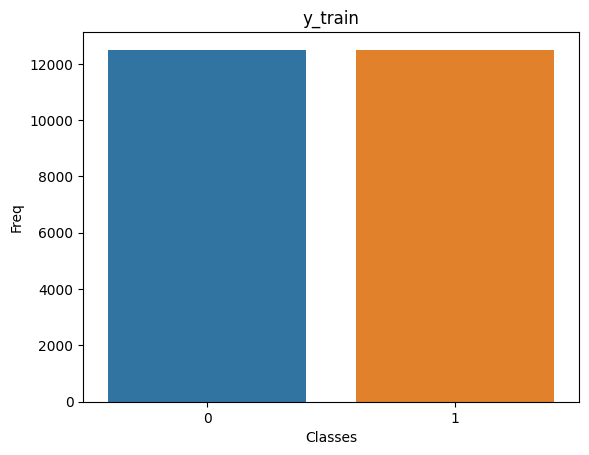

In [ ]:
# countplot ile görselleştirelim
plt.figure()
sns.countplot(x=y_train)
plt.xlabel("Classes")
plt.ylabel("Freq")
plt.title("y_train")
plt.show()

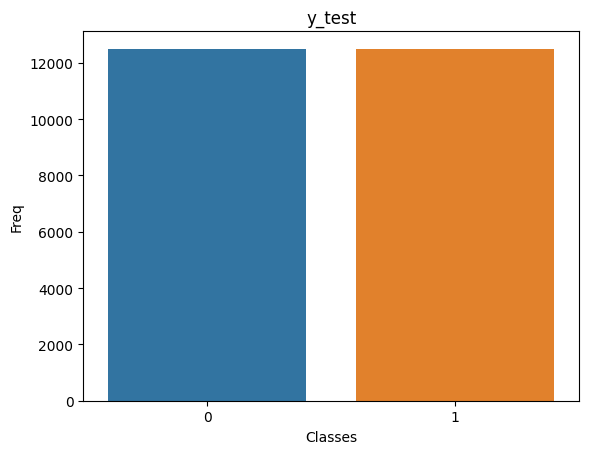

In [ ]:
# countplot ile görselleştirelim
plt.figure()
sns.countplot(x =y_test)
plt.xlabel("Classes")
plt.ylabel("Freq")
plt.title("y_test")
plt.show()

In [ ]:
for i, ii in zip(x_train[:3], x_test[:3]): # bu veri setlerinde bulunan her bir yorumun uzunluğu
  print(i)
  print(ii)

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
[1, 591, 202, 14, 31, 6, 717, 10, 10

In [ ]:
# her bir yorumdaki toplam kelime sayısı
review_len_train = []
review_len_test = []

for i, ii in zip(x_train, x_test): # bu veri setlerinde bulunan her bir yorumun uzunluğu
  review_len_train.append(len(i)) # i, bir yorumu temsil eder
  # 25.000 tane yorumun sırasıyla her birine erişir ve uzunluklarına bakar
  review_len_test.append(len(ii))

In [ ]:
# test veri setinde ek küçük yorum kaç kelimeden oluşuyor
min(review_len_test)

7

In [ ]:
# train veri setinde ek küçük yorum kaç kelimeden oluşuyor
min(review_len_train)

11

<ipython-input-19-7599386ec338>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(review_len_train, hist_kws = {"alpha":0.3}) # train için
<ipython-input-19-7599386ec338>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(review_len_test, hist_kws={"alpha":0.3}) # test için


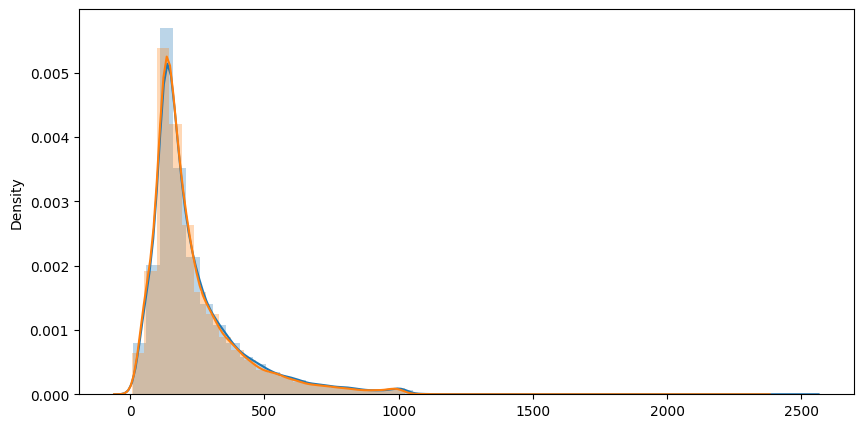

In [ ]:
# yorumlardaki kelime sayılarının dağılımları
# alpha ile saydamlık ekledim
plt.figure(figsize=(10, 5))
sns.distplot(review_len_train, hist_kws = {"alpha":0.3}) # train için
sns.distplot(review_len_test, hist_kws={"alpha":0.3}) # test için
plt.show()

mavi ve turuncu var. tamamen üst üste oturmuş 2 tane farklı veri setinin histogramıdır. kuyruk sağa doğru uzamış burada bir pozitif çarpıklık söz konusudur yani normal dağılıma sahip değildir.

In [ ]:
# medyan ve ortalama değerlerine bakalım
# iki histogram aynı olduğundan sadece bir tanesinin medyan ve ortalama değerine baksam yeterli olur
print("Train mean:", np.mean(review_len_train))
print("Train median:", np.median(review_len_train))
print("Train mode:", stats.mode(review_len_train)) # en çok tekrar eden değer, grafikteki tepe noktasıdır

Train mean: 238.71364
Train median: 178.0
Train mode: ModeResult(mode=132, count=196)


keras kütüphanesinden kullanacağım neural network'ün input parametreleri fix olmalı ama buradaki dağılımda çarpıklık vardır. bir yorumda 2500 kelime varken diğerinde 11 tane kelime vardır dolayısıyla burada belirli bir sayı belirlemek zorundayım ve tüm yorumları belirlenen uzunluğa getirmeliyim bunun için mod değerini(132) kullanabiliriz. dolayısıyla moddan uzun olanları kırpacağız az olanları ise 0 ile dolduracağız

In [ ]:
# kaç tane kelime var
# buradaki kelimelerin hepsinin bir integer karşılığı var
# kelimeleri integer olarak vermiş
# kelimelerin indeksini alıyorum
word_index = imdb.get_word_index()
print(type(word_index)) # <class 'dict'>

<class 'dict'>


word_index

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951...}

In [ ]:
len(word_index)
# 88584 tane kelime vardır

88584

In [ ]:
# en çok kullanılan kelimenin the olduğu görülür.
word_index["the"] # the 1 ile temsil edilir

1

In [ ]:
# verilen sayıya göre kelime tespiti
for keys, values in word_index.items():
  if values == 1:
    print(keys)

the


In [ ]:
# verilen sayıya göre kelime tespiti
for keys, values in word_index.items():
  if values == 11: # 11. en çok kullanılan kelime
    print(keys) # of, 11 integer değeri ile temsil edilir
  if values == 4: # 4. en çok kullanılan kelime
    print(keys) # this, 4 integer değeri ile temsil edilir

of
this


In [ ]:
d = x_train[0] # birinci yorum
d[:4]

[1, 14, 22, 16]

word_index.items()

('ungoriest', 86786), ('asheville', 86787)...

In [ ]:
# sayılarla temsil edilen kelimeleri, kelime karşılığına çevireceğiz
def whatItSay(index = 24):
  reverse_index = dict([(value, key) for (key, value) in word_index.items()])
  decode_review = " ".join([reverse_index.get(i - 3, "!") for i in x_train[index]])
  print(decode_review)
  print(y_train[index]) # yorum olumlu(1) mu olumsuz(0) mu
  return decode_review

In [ ]:
decoded_review = whatItSay() # 24. yorum

! the original demille movie was made in 1938 with frederic march a very good film indeed hollywood's love of remakes brings us a fairly interesting movie starring yul brynner he of course was brilliant as he almost always seemed to be in all of his movies charlton heston as andrew jackson was a stroke of genius however the movie did tend to get a little long in places it does not move at the pace of the 1938 version still it is a fun movie that should be seen at least once
1


In [ ]:
# 24. yorum
x_train[24][:3]

[1, 4, 204]

In [ ]:
reverse_index = dict([(value, key) for (key, value) in word_index.items()])

In [ ]:
# belirtilen key yoksa "Not Found" geri dönderir
reverse_index.get(-2, "Not Found")

'Not Found'

In [ ]:
[reverse_index.get(i-3, "!") for i in x_train[24]][:3]

['!', 'the', 'original']

<a id="4" ></a>
## Preprocess: Padding ve Eğitim/Test Verisinin Ayrılması

EDA sonucunda çıkan bilgiler doğrultusunda veriyi traning işlemine hazırlayacağız.

In [ ]:
# yorumlar 88584 tane benzersiz kelimeden oluşuyor
len(reverse_index)

88584

In [ ]:
# 88584 çok fazla olduğundan 15000 ile sınırlayalım
num_words = 15000

In [ ]:
# num_words=15000 en çok kullanılan 15000 kelimeyi getir diğerlerini getirme
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = num_words)

In [ ]:
# yorumlar farklı boyutta olduğundan padding işlemi uygulayacağız
# eğer belirlenen boyuttan fazla ise kırpacağız kısa olanları ise 0 ile dolduracağız

In [ ]:
# yorumlardaki kelime dağılımlarına baktığımızda
# bir yorumda genellikle 132 tane kelimenin olduğunu görmüştük (mod)
maxlen = 132

In [ ]:
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [ ]:
# 5. yoruma bakalım
x_train[5] # 132'ye tamamlayabilmek için başına 0'lar eklenmiş
# sıfırın kelime olarak bir karşılığı yoktur

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    1,  778,  128,   74,   12,  630,  163,   15,    4, 1766,
       7982, 1051,    2,   32,   85,  156,   45,   40,  148,  139,  121,
        664,  665,   10,   10, 1361,  173,    4,  749,    2,   16, 3804,
          8,    4,  226,   65,   12,   43,  127,   24,    2,   10,   10],
      dtype=int32)

In [ ]:
# belirtilen key yoksa "Not Found" geri dönderir
reverse_index.get(0, "Not Found")

'Not Found'

In [ ]:
# ilk 10 yorumun uzunluğu
for i in x_train[:10]:
  print(len(i)) # bütün yorumların uzunluğunun 132 olduğu görülür

132
132
132
132
132
132
132
132
132
132


In [ ]:
# 5. yorumun kelime karşılığını getirir
# 0 ise olumsuz, 1 ise olumlu
decoded_review = whatItSay(5)

! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! begins better than it ends funny that the russian submarine crew ! all other actors it's like those scenes where documentary shots br br spoiler part the message ! was contrary to the whole story it just does not ! br br
0


In [ ]:
decoded_review

"! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! begins better than it ends funny that the russian submarine crew ! all other actors it's like those scenes where documentary shots br br spoiler part the message ! was contrary to the whole story it just does not ! br br"

<a id="5" ></a>
## Recurrent Neural Network

Metin verileri kullanacağımız için bir Recurrent Neural Network (Tekrarlayan Sinir Ağı) kullanılacak. 'Recurrent' (tekrarlayan) ifadesi, zaman bağımlı verileri işlediğimizde özellikle önemlidir. Metin işleminde, veriler zaman sırasına göre dizilmiştir. Burada, kelimeler ardışık olarak gelir, ve bir kelimenin bir başka kelimenin önünde ya da arkasında olması, cümlelerin olumlu mu yoksa olumsuz mu olduğunda önemli bir kriterdir.

In [ ]:
# Sequential yapının yani dizinin içerisine gerekli olan layer'ları tek tek ekleyeceğim
rnn = Sequential()

In [ ]:
# Embedding, integer'ları belirli boyutlarda yoğunluk vektörlerine çevirmemizi sağlayan bir yapıydı
# input boyutu: 15000, output boyutu, 132
rnn.add(Embedding(num_words, 32, input_length = len(x_train[0])))

Bu Python kodu, bir derin öğrenme modeli oluştururken kullanılan bir Keras Sequential modelini tanımlıyor gibi görünüyor. Kod, bir dil işleme veya metin sınıflandırma görevi için bir Rekürrensin (RNN) başlangıç katmanını oluşturuyor.

Aşağıda, bu kodun her iki satırını ayrı ayrı açıklayalım:

1. `rnn = Sequential()`: Bu satırda, Keras kütüphanesinin bir parçası olan `Sequential` modeli oluşturuluyor. `Sequential` model, katmanları sıralı bir şekilde eklemenizi ve bir derin öğrenme modelini basitçe inşa etmenizi sağlayan bir yapıdır.

2. `rnn.add(Embedding(num_words, 32, input_length=len(x_train[0])))`: Bu satırda, modelin ilk katmanı ekleniyor. Bu katman bir gömme (Embedding) katmanıdır.

   - `Embedding` katmanı, genellikle dil işleme görevlerinde kullanılır ve kelime gömme işlemi için tasarlanmıştır. Bu işlem, kelime dağarcığını belirli bir boyuttaki vektörlerle temsil etmeyi içerir. `num_words` kelime dağarcığı boyutunu belirtir.
   - `32` ikinci bir argüman olarak verilen sayı, kelime gömme vektörlerinin boyutunu belirtir. Her kelime bu boyutta bir vektörle temsil edilir.
   - `input_length` ise giriş dizisinin uzunluğunu belirtir. Bu, her bir giriş örneğinin ne kadar uzun olduğunu gösterir. `x_train` veri kümesinin ilk öğesi (örneğin, bir metin dizisi) bu uzunluğa sahip olmalıdır.

Bu kod parçası, bir metin sınıflandırma veya dil modeli oluştururken kullanılan tipik bir başlangıç katmanıdır. Bu başlangıç katmanı, metin verilerini daha sonra ekleyeceğiniz RNN veya başka bir tür katmana giriş olarak verebilmeniz için gerekli kelime gömme işlemini gerçekleştirir.

In [ ]:
# output boyutu, input_shape(15000 tane kelime olucak ve bu yorumların içerisindeki kelime sayısı 132 olacak)
rnn.add(SimpleRNN(16, input_shape = (num_words, maxlen), return_sequences=False, activation="relu"))

In [ ]:
# modelin çıkış katmanını tanımlar ve sonuçları hesaplamak için kullanılır.
# Modelin eğitildikten sonra, bu katmanın çıkışı, verilen girişe göre tahminler içerecektir.
rnn.add(Dense(1))

In [ ]:
# sınıflandırma işlemini gerçekleştirebilmek için aktivasyon fonksiyonu eklemeliyiz
rnn.add(Activation("sigmoid")) # sigmoid çünkü binary sınıflandırma yapabilmek için

In [ ]:
print(rnn.summary()) # layerların sayısı

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 132, 32)           480000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                784       
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 480801 (1.83 MB)
Trainable params: 480801 (1.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
rnn.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

Bu satır, Keras Sequential modelinin derlenme (compile) işlemini gerçekleştiriyor. Modelin derlenmesi, eğitim öncesi ayarlarını ve eğitim sırasında kullanılacak kayıp (loss) fonksiyonunu, optimize ediciyi ve metrikleri belirlemek anlamına gelir. İşte bu satırın ayrıntılı açıklaması:

- `loss="binary_crossentropy"`: Bu argüman, eğitim sırasında kullanılacak kayıp fonksiyonunu belirtir. "binary_crossentropy", ikili sınıflandırma problemleri için sıkça kullanılan bir kayıp fonksiyonudur. Bu fonksiyon, modelin tahminlerini gerçek etiketlerle karşılaştırır ve bir hata değeri hesaplar. Model, bu hatayı minimize etmek için eğitilir. İkili sınıflandırma problemlerinde kullanılan diğer bir kayıp fonksiyonu da "mean_squared_error" olabilir.

- `optimizer="rmsprop"`: Bu argüman, modelin optimize ediciyi belirler. "rmsprop" (RMSprop) yaygın olarak kullanılan bir optimize edici algoritmadır. Optimize edici, modelin kaybını minimize etmek ve ağırlıkları güncellemek için kullanılır. Başka optimize edici seçenekleri de mevcuttur, örneğin "adam", "sgd" (stochastic gradient descent) veya "adamax" gibi.

- `metrics=["accuracy"]`: Bu argüman, modelin eğitim sırasında izlenecek metrikleri belirtir. Burada, sadece "accuracy" (doğruluk) metriği belirtilmiş. Bu, eğitim sırasında modelin doğru tahminlerin yüzdesini hesaplamak için kullanılır. İkili sınıflandırma problemleri için sıkça kullanılan bir metrik olan doğruluk, modelin performansını değerlendirmek için önemlidir. Başka metrikler de ekleyebilirsiniz, örneğin "precision", "recall", "f1-score" gibi sınıflandırma metrikleri.

Bu kod, modelin derleme aşamasını tamamlar ve model eğitildiğinde kullanılacak kayıp fonksiyonunu, optimize ediciyi ve metrikleri tanımlar. Model, bu ayarlarla eğitildiğinde, belirtilen kaybı minimize etmek ve belirtilen metrikleri iyileştirmek için optimize edilecektir.

<a id="6" ></a>
## Recurrent Neural Network Eğitimi

In [ ]:
# training, fit etme işlemi
history = rnn.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=128)
# train accuracy değeri - test accuracy değeri

Epoch 1/5
196/196 [==============================] - 7s 27ms/step - loss: 0.6303 - accuracy: 0.6483 - val_loss: 0.5213 - val_accuracy: 0.7898
Epoch 2/5
196/196 [==============================] - 5s 27ms/step - loss: 0.4798 - accuracy: 0.8154 - val_loss: 0.4383 - val_accuracy: 0.8162
Epoch 3/5
196/196 [==============================] - 6s 30ms/step - loss: 0.3836 - accuracy: 0.8463 - val_loss: 0.3748 - val_accuracy: 0.8356
Epoch 4/5
196/196 [==============================] - 5s 27ms/step - loss: 0.3190 - accuracy: 0.8688 - val_loss: 0.3394 - val_accuracy: 0.8530
Epoch 5/5
196/196 [==============================] - 6s 32ms/step - loss: 0.2707 - accuracy: 0.8898 - val_loss: 0.3300 - val_accuracy: 0.8555


Bu kod, Keras Sequential modelin eğitim işlemini başlatır. Eğitim işlemi, modelin verilere uyum sağlamasını ve öğrenmesini sağlar. İşte bu satırın ayrıntılı açıklaması:

- `x_train`: Bu argüman, eğitim verilerini temsil eder. Bu veriler, modelin öğrenme işlemini gerçekleştirmesi için kullanılır. `x_train`, özellik matrislerini içerir ve her bir satır bir veri örneğini temsil eder.

- `y_train`: Bu argüman, eğitim verilerinin hedef etiketlerini temsil eder. Yani, her bir `x_train` veri örneğiyle ilişkilendirilen hedef değerleri içerir.

- `validation_data=(x_test, y_test)`: Bu argüman, modelin eğitim sırasında doğrulama verilerini kullanmasını sağlar. Model, eğitim verileri üzerinde eğitildikten sonra, doğrulama verileri üzerinde nasıl performans gösterdiğini değerlendirmek için kullanılır. `x_test` doğrulama verilerini ve `y_test` doğrulama hedef etiketlerini içerir.

- `epochs=5`: Bu argüman, modelin eğitimini kaç dönem (epochs) boyunca yapacağını belirtir. Bir dönem, tüm eğitim verilerinin model tarafından bir kez kullanılması anlamına gelir. Yani, model beş dönem boyunca eğitilecek ve her dönemde tüm eğitim verileri üzerinden geçecektir.

- `batch_size=128`: Bu argüman, her eğitim dönemi sırasında kullanılacak mini grup (batch) boyutunu belirtir. Eğitim verileri, küçük gruplara bölünerek (mini gruplar) model üzerinde eğitilir. Bu, eğitim işlemini hızlandırmak ve bellek kullanımını azaltmak için kullanılır. Burada, her bir mini grup 128 örnek içerecektir.

Bu kod, modelin eğitim işlemini başlatır ve belirtilen dönem (epoch) sayısı boyunca modelin verilere uyum sağlamasını ve öğrenmesini sağlar. Eğitim sırasında belirli aralıklarla (her bir dönem sonunda) doğrulama verileri üzerinde modelin performansını değerlendirir. Eğitim tamamlandığında, modelin eğitilmiş ağırlıkları ve parametreleri elde edilir ve bu model kullanılarak yeni verilere tahminler yapılabilir.

In [ ]:
history.history # dict

{'loss': [0.6302587985992432,
  0.47981977462768555,
  0.3836249113082886,
  0.3190488815307617,
  0.2707282602787018],
 'accuracy': [0.6482800245285034,
  0.8154000043869019,
  0.8463199734687805,
  0.8688399791717529,
  0.8898000121116638],
 'val_loss': [0.5213482975959778,
  0.4382639527320862,
  0.37475910782814026,
  0.33939793705940247,
  0.33003005385398865],
 'val_accuracy': [0.7897599935531616,
  0.8162400126457214,
  0.8355600237846375,
  0.8529599905014038,
  0.8555200099945068]}

<a id="7" ></a>
## Sonuçların Değerlendirilmesi

In [ ]:
score = rnn.evaluate(x_test, y_test)
print("Accuracy: %{}".format(score[1]*100))

782/782 [==============================] - 5s 6ms/step - loss: 0.3300 - accuracy: 0.8555
Accuracy: %85.55200099945068


In [ ]:
# val_loss: 0.3300 - val_accuracy: 0.8555
score # %85'lik bir accuracy

[0.33002999424934387, 0.8555200099945068]

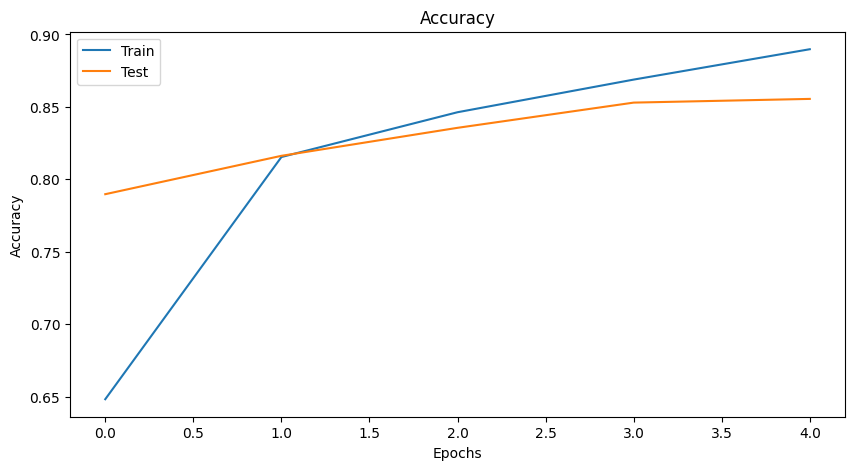

In [ ]:
# accuracy değerinin nasıl değiştiğini bir plot üzerinde görelim
plt.figure(figsize=(10,5))
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Test") # Test Accuracy değeri
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend() # label'ların yazdırılması için
plt.show()

Epochs değerlerine göre train ve test setindeki accuracy değerlerinin değişimleri

En iyi değer 1. epoch'da elde edilmiştir. yaklaşık olarak %81'lik bir başarım söz konusudur.

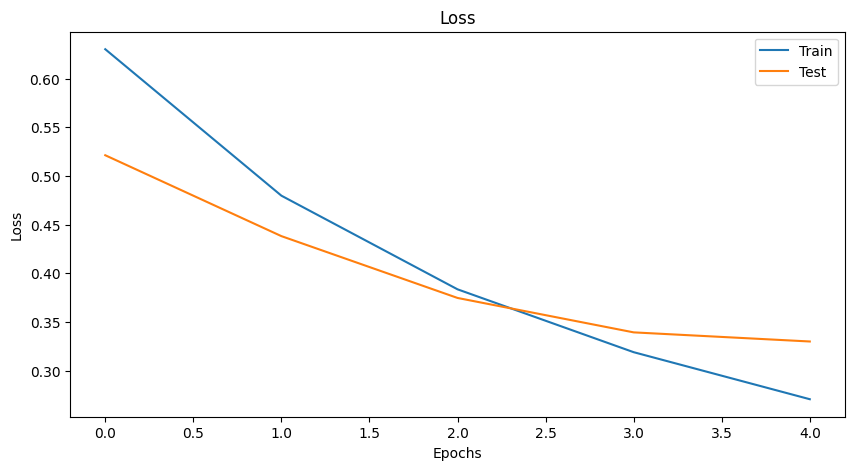

In [ ]:
# loss değerinin nasıl azaldığını gözlemleyelim
# loss değerinin nasıl değiştiğini bir plot üzerinde görelim
plt.figure(figsize=(10,5))
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Test") # Test Accuracy değeri
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend() # label'ların yazdırılması için
plt.show()

Epoch arttıkça train loss sürekli azalır ve overfit'e doğru gidiyor ama test loss bir yere kadar azaldıktan sonra artmaya başlar.